In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Problem: How to model probability $p$ using a linear model?
## How to derive $p : \mathbb{R} \to (0, 1)$?

***

## Idea: Start by deriving the inverse $p^{-1} : (0,1) \to \mathbb{R}$

### 1. Try a linear function $p^{-1}=ax + b$

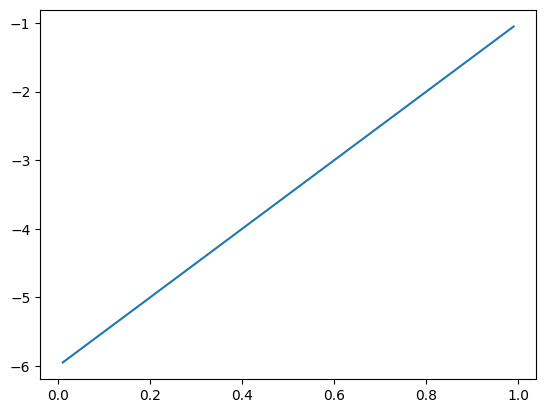

In [2]:
x = np.linspace(0.01, 0.99, 100)
p_inverse = lambda a, b, x: a*x + b
a, b = 5, -6
plt.plot(x, p_inverse(a, b, x))
plt.show()

### Conclusion: The linear function is not sufficient in producing an output which spans the whole $\mathbb{R}$.

***

### 2. Try odds $p^{-1} =\frac{x}{1-x}$

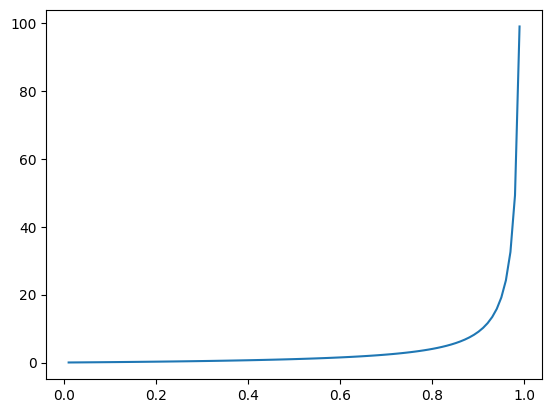

In [3]:
odds = x / (1 - x)
plt.plot(x, odds)
plt.show()

### Conclusion: The output of odds spans $\mathbb{R}^{+}$, still not sufficient.

***

### 3. Try log odds $p^{-1} =\log{\left (\frac{x}{1-x} \right)}$

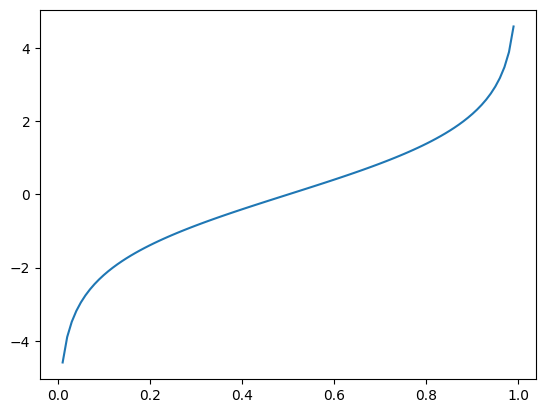

In [4]:
log_odds = np.log(odds)
plt.plot(x, log_odds)
plt.show()

### Conclusion: The output of log odds spans the whole $\mathbb{R}$.

***

### Deriving $p$ from $p^{-1}$ we obtain

$$p = \frac{1}{1 + e^{-x}}$$

### which is known as the sigmoid function $\sigma(x)$.

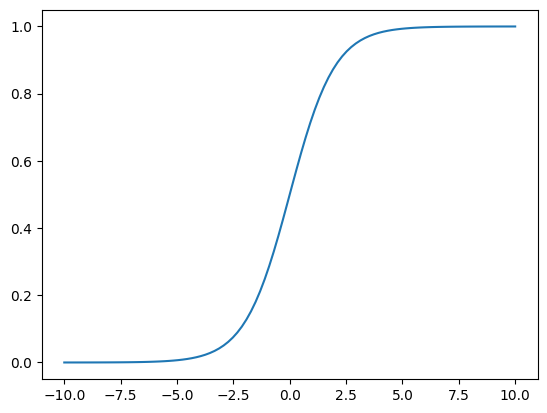

In [6]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
x = np.linspace(-10, 10, 100)
plt.plot(x, sigmoid(x))
plt.show()

### Assuming linear form of log odds

$$\log{\left (\frac{p}{1-p} \right)} = \mathbf{w}^\intercal \mathbf{x} + b$$

### we arrive at the logistic regression formula

$$p = \frac{1}{1 + e^{-(\mathbf{w}^\intercal \mathbf{x} + b)}}$$

***

# Logistic regression

### Prediction

$$
\begin{align*}
h(\mathbf{x}) &= \mathbf{w^\intercal x} + b \\
y &= \sigma(h(\mathbf{x})) \\
\sigma(x) &= \frac{1}{1 + e^{-x}}
\end{align*}
$$

### Cross entropy loss
$$
\begin{align*}
L(\hat{y}, y) &= -\left[ y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right]
\end{align*}
$$

### Cross entropy loss partial derivatives
$$
\begin{align*}
\frac{\partial L}{\partial \hat{y}} &= - \left[ \frac{y}{\hat{y}} - \frac{1 - y}{1 - \hat{y}} \right] = \frac{\hat{y} - y}{\hat{y} (1 - \hat{y})} \\
\frac{\partial \hat{y}}{\partial \mathbf{w}} &= \hat{y}(1- \hat{y}) \mathbf{x} \\
\frac{\partial \hat{y}}{\partial b} &= \hat{y}(1- \hat{y}) \\
\end{align*}
$$

### Error function
$$
\begin{align*}
E(\mathbf{w}|\mathcal{D}) &= \frac{1}{N} \sum_{i = 1}^{N} L(\hat{y_i}, y_i) \\
&= - \frac{1}{N} \sum_{i = 1}^{N} \left[ y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) \right] \\
\end{align*}
$$

### Error function gradients
$$
\begin{align*}
\frac{\partial E}{\partial \mathbf{w}} &= \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial \mathbf{w}} = (\hat{y} - y) \mathbf{x} \\
\frac{\partial E}{\partial b} &= \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial b} = \hat{y} - y
\end{align*}
$$

### Gradient descent updates
$$
\begin{align*}
\Delta \mathbf{w} &= \frac{\partial E}{\partial \mathbf{w}} =  (\hat{y} - y) \mathbf{x}\\
\Delta b &= \frac{\partial E}{\partial b} = \hat{y} - y \\
\mathbf{w}_{t + 1} &= \mathbf{w}_{t} - \alpha \Delta \mathbf{w} \\
b_{t + 1} &= b_t - \alpha \Delta b
\end{align*}
$$

In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

In [3]:
class LogisticRegression:

    def __init__(self, lr: float = 1e-3, max_iter: int = 1000):
        """
        Logistic Regression implemented using the gradient descent algorithm.

        Parameters
        ----------
        learning_rate : float, default=0.001
            Step size used in gradient descent.

        max_iter : int, default=1000
            Number of iterations of gradient descent.

        Attributes
        ----------
        bias : numpy.float64
            Coefficient obtained by fitting the model.

        weights : numpy.ndarray 
            Vector of coefficients obtained by fitting the model.
        """
        self.lr = lr
        self.max_iter = max_iter

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Fit the Logistic Regression model.

        Parameters
        ----------
        X : numpy.ndarray
            Training data of shape (n_samples, n_features).

        y : numpy.ndarray
            Target values of shape (n_samples,).

        Returns
        -------
        None
        """
        # Initialize weights to a zero vector of shape (n_features,)
        self.weights = np.zeros(X.shape[1])
        # Initialize bias to zero
        self.bias = 0

        # Repeating gradient descent steps
        for _ in range(self.max_iter):

            # Predict values using current parameters
            y_pred =  self.predict(X)

            # Gradient of the error function with respect to weights, calculated using the entire training data
            dw = np.dot(X.T, (y_pred - y))
            # Gradient of the error function with respect to bias
            db = np.sum(y_pred - y)

            # Update the weights
            self.weights -= self.lr * dw
            # Update the bias
            self.bias -= self.lr * db

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict using the Logistic Regression model.

        Parameters
        ----------
        X : numpy.ndarray
            Samples of shape (n_samples, n_features).

        Returns
        -------
        y : numpy.ndarray
            Predicted values of shape (n_samples,).
        """
        # Predicted values are the dot product of samples and weights plus bias
        y_pred = np.dot(X, self.weights) + self.bias
        # Predicted values are passed to the sigmoid function to be scaled into the range (0, 1)
        return self.sigmoid(y_pred)
    
    def sigmoid(self, X: np.ndarray) -> np.ndarray:
        """
        Sigmoid activation function.

        Parameters
        ----------
        X : numpy.ndarray
            Samples of shape (n_samples, n_features).

        Returns
        -------
        y : numpy.ndarray
            Predicted values of shape (n_samples,).
        """
        return 1 / (1 + np.exp(-X))
    
    def cross_entropy_loss(self, y_pred, y_true):
        """
        Binary Cross Entropy loss function.

        Parameters
        ----------
        y_pred : numpy.ndarray
            Predicted values of shape (n_samples,).
        
        y_true : numpy.ndarray
            True values of shape (n_samples,).

        Returns
        -------
        loss : numpy.ndarray
            Array of loss values for every sample.
        """
        return -1 * (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def error_function(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Error function calculated as the mean of the loss function.

        Parameters
        ----------
        X : numpy.ndarray
            Samples of shape (n_samples, n_features).

        y : numpy.ndarray
            Predicted values of shape (n_samples,).

        Returns
        -------
        error : float
            Mean of the loss values calculated using the loss function. 
        """
        y_pred = self.predict(X)
        return np.mean(self.cross_entropy_loss(y_pred, y))
    
    def accuracy(self, X: np.ndarray, y: np.ndarray):
        """
        Accuracy function.

        Parameters
        ----------
        X : numpy.ndarray
            Samples of shape (n_samples, n_features).

        y : numpy.ndarray
            Predicted values of shape (n_samples,).

        Returns
        -------
        accuracy : float
            Ratio of correctly classified samples and the total number of samples.
        """
        return np.mean(np.round(self.predict(X), 0) == y.reshape(-1))

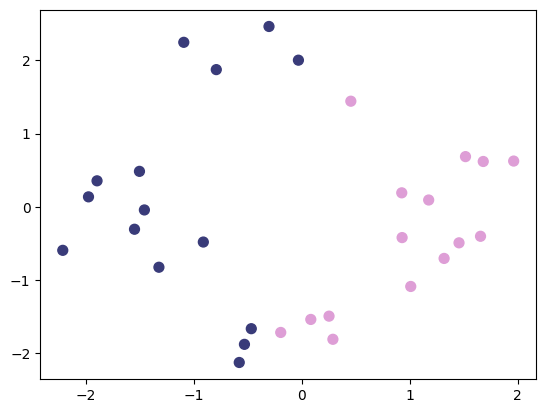

In [6]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=30, n_features=2, n_informative=2, n_redundant=0)
plot_2d_clf_problem(X, y)

Accuracy: 1.0


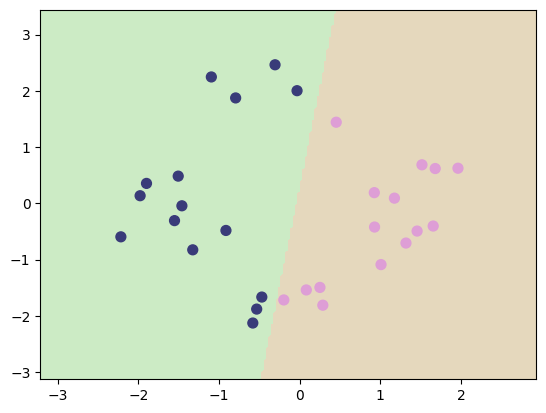

In [7]:
model = LogisticRegression(lr=3e-3, max_iter=5000)
model.fit(X, y)
print(f'Accuracy: {model.accuracy(X, y)}')
plot_2d_clf_problem(X, y, lambda x : model.predict(x) > 0.5)